In [87]:

import os 
import time

import pandas as pd

import seaborn as sns
import mplfinance as mpf
import matplotlib.pyplot as plt
from binance.client import Client

In [88]:
# Lưu ý: Client.KLINE_INTERVAL_* là các hằng số định nghĩa khoảng thời gian.
# Ví dụ: Client.KLINE_INTERVAL_1HOUR, Client.KLINE_INTERVAL_1DAY, v.v.

def get_binance_klines(symbol, interval, start_str, end_str=None):
    """
    Lấy dữ liệu nến (klines) từ Binance.

    :param symbol: Cặp giao dịch (ví dụ: 'BTCUSDT', 'ETHUSDT').
    :param interval: Khoảng thời gian (ví dụ: Client.KLINE_INTERVAL_1HOUR).
    :param start_str: Thời điểm bắt đầu (ví dụ: '1 Jan, 2024' hoặc '3 days ago').
    :param end_str: Thời điểm kết thúc (mặc định là hiện tại).
    :return: DataFrame chứa dữ liệu giá theo thời gian.
    """
    # Không cần API Key và Secret Key nếu chỉ lấy dữ liệu công khai (public data)
    # Tuy nhiên, việc khởi tạo client là cần thiết để sử dụng các hàm của thư viện.
    # Nếu bạn có key, có thể thay thế bằng key thật để tránh bị giới hạn rate-limit
    # Tốt nhất là lưu API key và secret key vào biến môi trường hoặc file riêng
    api_key = '' # Thay bằng key thật của bạn nếu có
    api_secret = '' # Thay bằng secret thật của bạn nếu có
    client = Client(api_key, api_secret)

    # Lấy dữ liệu klines
    print(f"Đang tải dữ liệu cho {symbol} từ {start_str}...")
    klines = client.get_historical_klines(
        symbol=symbol,
        interval=interval,
        start_str=start_str,
        end_str=end_str
    )

    # Chuyển dữ liệu nến thô sang DataFrame
    data = pd.DataFrame(klines, columns=[
        'Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 
        'Close Time', 'Quote Asset Volume', 'Number of Trades', 
        'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume', 'Ignore'
    ])

    # Chuyển cột thời gian từ timestamp (ms) sang datetime
    data['Open Time'] = pd.to_datetime(data['Open Time'], unit='ms')
    data['Close Time'] = pd.to_datetime(data['Close Time'], unit='ms')

    # Đặt cột Open Time làm index
    data.set_index('Open Time', inplace=True)

    # Chuyển các cột giá trị và khối lượng sang kiểu số (float)
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'Number of Trades']
    data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric)

    # Chỉ giữ lại các cột quan trọng
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

    print("Tải dữ liệu hoàn tất.")
    return data

In [89]:
# 1. Định nghĩa các tham số
symbol = 'BTCUSDT'
interval = Client.KLINE_INTERVAL_1DAY # Dữ liệu theo ngày
start_date = '1 Oct, 2024' # Có thể dùng định dạng tiếng Anh tự nhiên
end_date = '1 Jul, 2025'

# 2. Gọi hàm và nhận DataFrame
df = get_binance_klines(
                            symbol=symbol,
                            interval=interval,
                            start_str=start_date,
                            end_str=end_date
                            )

# 3. Hiển thị kết quả
print("\n--- 5 Dòng đầu tiên của dữ liệu BTCUSDT ---")
print(df.head())

print("\n--- 5 Dòng cuối cùng của dữ liệu BTCUSDT ---")
print(df.tail())

print("\n--- Thông tin DataFrame ---")
print(df.info())

Đang tải dữ liệu cho BTCUSDT từ 1 Oct, 2024...
Tải dữ liệu hoàn tất.

--- 5 Dòng đầu tiên của dữ liệu BTCUSDT ---
                Open      High       Low     Close       Volume
Open Time                                                      
2024-10-01  63327.60  64130.63  60164.00  60805.78  43671.48108
2024-10-02  60804.92  62390.31  60000.00  60649.28  31534.70118
2024-10-03  60649.27  61477.19  59828.11  60752.71  26221.43472
2024-10-04  60752.72  62484.85  60459.90  62086.00  21294.65994
2024-10-05  62086.00  62370.56  61689.26  62058.00   7807.46141

--- 5 Dòng cuối cùng của dữ liệu BTCUSDT ---
                 Open       High        Low      Close       Volume
Open Time                                                          
2025-06-27  106947.06  107735.34  106356.76  107047.59  12232.44042
2025-06-28  107047.58  107577.75  106811.51  107296.79   3282.17352
2025-06-29  107296.79  108528.50  107172.52  108356.93   6831.73640
2025-06-30  108356.93  108789.99  106733.33  107146.

In [90]:
# 2. Hàm Tạo Chỉ báo Kỹ thuật (CHỈ DÙNG PANDAS/NUMPY)
def create_technical_indicators_manual(df: pd.DataFrame) -> pd.DataFrame:
    """
    Tính toán các chỉ báo kỹ thuật (MA, RSI, BB, MACD) 
    chỉ sử dụng pandas và numpy.
    """
    if df.empty:
        return df
        
    print("📈 Đang tính toán các chỉ báo kỹ thuật thủ công...")

    # --- 1. Trung bình trượt đơn giản (SMA) ---
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    
    # --- 2. Trung bình trượt hàm mũ (EMA) ---
    # `pandas.Series.ewm()` cung cấp cách tính EMA chính xác
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()

    # --- 3. Dải Bollinger (BB) ---
    window = 20
    df['BB_Mid'] = df['Close'].rolling(window=window).mean()
    df['BB_Std'] = df['Close'].rolling(window=window).std()
    df['BB_High'] = df['BB_Mid'] + (df['BB_Std'] * 2)
    df['BB_Low'] = df['BB_Mid'] - (df['BB_Std'] * 2)
    df.drop(columns=['BB_Std'], inplace=True) # Xóa cột độ lệch chuẩn sau khi tính

    # --- 4. Chỉ số sức mạnh tương đối (RSI) ---
    window = 14
    # Tính sự khác biệt (Gain/Loss)
    delta = df['Close'].diff()
    # Phân loại tăng (gain) và giảm (loss)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    # Tính trung bình trượt hàm mũ (RSI sử dụng trung bình trượt hàm mũ)
    avg_gain = gain.ewm(span=window, adjust=False).mean()
    avg_loss = loss.ewm(span=window, adjust=False).mean()
    
    # Tính RS và RSI
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))
    
    # --- 5. MACD (Moving Average Convergence Divergence) ---
    EMA_26 = df['Close'].ewm(span=26, adjust=False).mean()
    EMA_12 = df['Close'].ewm(span=12, adjust=False).mean()
    df['MACD'] = EMA_12 - EMA_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    print("✅ Tính toán chỉ báo thủ công hoàn tất.")
    return df.dropna()

In [91]:
df = create_technical_indicators_manual(df)

📈 Đang tính toán các chỉ báo kỹ thuật thủ công...
✅ Tính toán chỉ báo thủ công hoàn tất.


In [92]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'EMA_12', 'BB_Mid',
       'BB_High', 'BB_Low', 'RSI_14', 'MACD', 'MACD_Signal'],
      dtype='object')

In [98]:
def plot_coin_klines_with_indicators(df, title='Biểu đồ Nến & Chỉ báo Kỹ thuật', show_volume=True):
    """
    Vẽ biểu đồ nến cho dữ liệu klines của coin, kèm theo các chỉ báo kỹ thuật.

    :param df: DataFrame chứa dữ liệu klines (Open Time là Index, có các cột: 'Open', 'High', 'Low', 'Close', 'Volume').
    :param title: Tiêu đề của biểu đồ.
    :param show_volume: Có hiển thị biểu đồ khối lượng hay không.
    """
    if not all(col in df.columns for col in ['Open', 'High', 'Low', 'Close']):
        print("Lỗi: DataFrame thiếu các cột giá cần thiết (Open, High, Low, Close).")
        return

    # --- 1. Chuẩn bị Dữ liệu & Tính toán Chỉ báo ---
    
    # Đảm bảo tên cột đúng chuẩn mplfinance (chữ cái đầu viết hoa)
    # df.columns = [col.capitalize() if col != 'Volume' else 'Volume' for col in df.columns]
    

    # Tính toán RSI (Relative Strength Index) - Sử dụng TA-Lib hoặc hàm tự tạo, 
    # nhưng để đơn giản và tránh phụ thuộc thư viện, ta chỉ dùng MA.
    # Tuy nhiên, mplfinance có thể vẽ RSI ở panel riêng.

    
    # --- 2. Định nghĩa Style và Plots Phụ ---

    # Style
    mc = mpf.make_marketcolors(up='g', down='r', inherit=True)
    s = mpf.make_mpf_style(marketcolors=mc, gridstyle='--', y_on_right=False)
    
    # Danh sách các plots phụ (addplots)
    apds = []

    # Thêm MA 20 và MA 50 vào cùng panel chính
    apds.append(mpf.make_addplot(df['SMA_20'], color='red', label='SMA 20'))
    apds.append(mpf.make_addplot(df['EMA_12'], color='blue', label='EMA 10'))
    apds.append(mpf.make_addplot(df['RSI_14'], color='orange', label='RSI 14'))
    apds.append(mpf.make_addplot(df['BB_High'], color='green', label='UB'))
    apds.append(mpf.make_addplot(df['BB_Low'], color='pink', label='LB'))

    # Thêm Volume (nếu được yêu cầu)
    if show_volume and 'Volume' in df.columns:
        # Volume cần nằm ở panel thứ 2 (panel=1)
        apds.append(
            mpf.make_addplot(df['Volume'], panel=1, type='bar', color='gray', secondary_y=False, ylabel='Volume')
        )
        
    # Thêm RSI (Ví dụ: Giả sử bạn đã tính được cột 'RSI' và muốn vẽ nó ở panel thứ 3)
    # Vì mplfinance không tích hợp tính toán RSI, đây là cách thêm một chỉ báo ở panel riêng biệt:
    # df['RSI'] = ... # (Cần code tính toán RSI hoặc dùng thư viện khác)
    # apds.append(
    #     mpf.make_addplot(df['RSI'], panel=2, ylabel='RSI', ylim=(0, 100), color='purple')
    # )


    # --- 3. Vẽ Biểu đồ ---
    
    # mplfinance tự động đặt các addplots vào cùng panel nếu không chỉ định 'panel' khác.
    print("Đang vẽ biểu đồ nến kèm MA và Volume...")
    try:
        mpf.plot(
            df, 
            type='candle',
            style=s,
            title=title,
            ylabel='Giá (Price)',
            volume=False, # Tắt volume mặc định để dùng addplot (giúp tùy biến tốt hơn)
            addplot=apds,
            figratio=(15,8), 
            figscale=1.2,
            show_nontrading=False,
            datetime_format='%Y-%m-%d',
            tight_layout=True
        )
    except Exception as e:
        print(f"Lỗi khi vẽ biểu đồ: {e}")

Đang vẽ biểu đồ nến kèm MA và Volume...


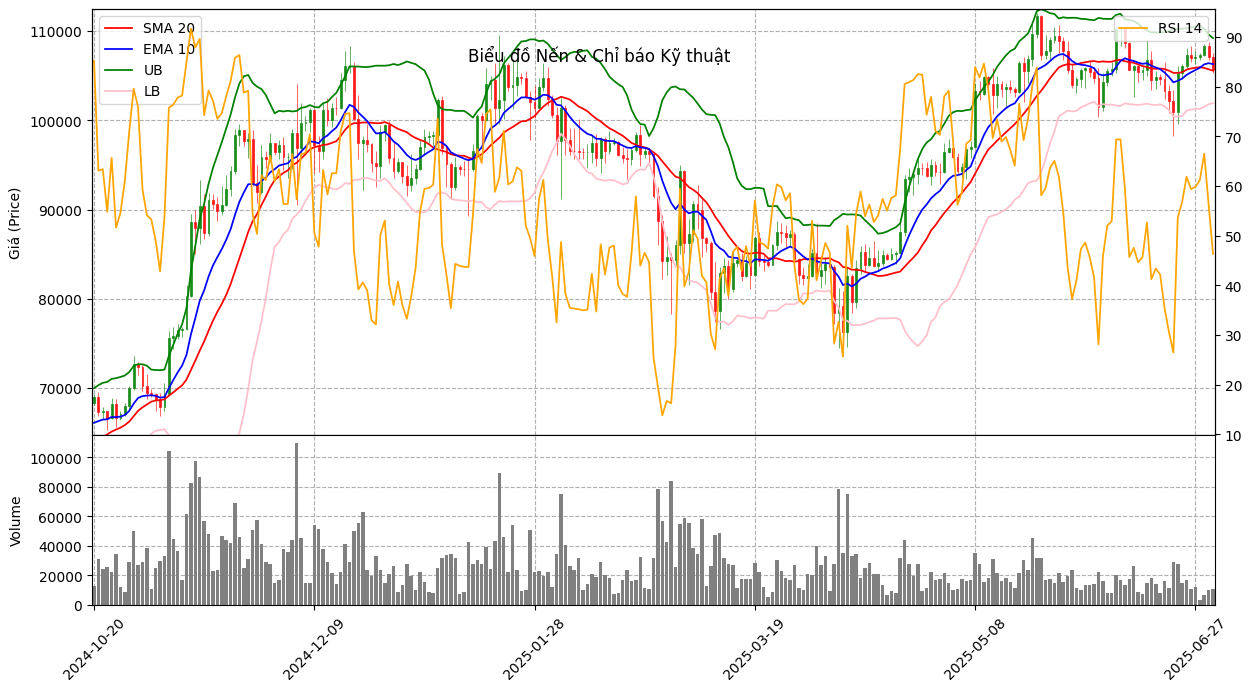

In [99]:
plot_coin_klines_with_indicators(df)

In [100]:
def display_and_visualize_data(df: pd.DataFrame, symbol: str):
    """
    Hiển thị dữ liệu, vẽ biểu đồ giá/chỉ báo và biểu đồ hộp (boxplot)
    cho tất cả các cột trong cùng 1 figure.
    """
    if df.empty:
        print("Không có dữ liệu để hiển thị.")
        return
        
    print(f"\n✨ Dữ liệu đã xử lý của {symbol} (5 hàng đầu):\n")
    print(df.tail()) 

    # ----------------------------------------------------
    # Tạo Figure có nhiều Subplot
    # ----------------------------------------------------
    fig = plt.figure(figsize=(18, 20))
    fig.suptitle(f'Phân tích Kỹ thuật và Ngoại lai cho {symbol}', fontsize=16, fontweight='bold')
    
    # === Subplot 1: Biểu đồ Giá và Chỉ báo (MA, BB) ===
    ax1 = fig.add_subplot(4, 1, 1) 
    ax1.plot(df.index, df['Close'], label='Giá Đóng', color='black', linewidth=1)
    ax1.plot(df.index, df['SMA_20'], label='SMA (20)', color='blue', linestyle='--')
    ax1.plot(df.index, df['EMA_12'], label='EMA (12)', color='purple', linestyle=':')
    
    # Vẽ dải Bollinger
    ax1.plot(df.index, df['BB_High'], label='BB High', color='red', alpha=0.5)
    ax1.plot(df.index, df['BB_Low'], label='BB Low', color='green', alpha=0.5)
    ax1.fill_between(df.index, df['BB_Low'], df['BB_High'], alpha=0.1, color='gray') 
    
    ax1.set_title(f'{symbol} - Biểu đồ Giá, SMA và Bollinger Bands')
    ax1.legend()
    ax1.grid(True, alpha=0.5)
    
    # === Subplot 2: Biểu đồ RSI ===
    ax2 = fig.add_subplot(4, 1, 2, sharex=ax1) 
    ax2.plot(df.index, df['RSI_14'], label='RSI (14)', color='orange')
    ax2.axhline(70, color='red', linestyle='--', alpha=0.7, label='Quá mua (70)')
    ax2.axhline(30, color='green', linestyle='--', alpha=0.7, label='Quá bán (30)')
    ax2.set_title('Chỉ số Sức mạnh Tương đối (RSI)')
    ax2.legend()
    ax2.grid(True, alpha=0.5)
    
    # === Subplot 3: Biểu đồ MACD ===
    ax3 = fig.add_subplot(4, 1, 3, sharex=ax1)
    ax3.plot(df.index, df['MACD'], label='MACD Line', color='blue')
    ax3.plot(df.index, df['MACD_Signal'], label='Signal Line', color='red')
    # Vẽ Histogram (Sự khác biệt)
    macd_hist = df['MACD'] - df['MACD_Signal']
    ax3.bar(df.index, macd_hist, width=1, color=['green' if val >= 0 else 'red' for val in macd_hist], alpha=0.6, label='Histogram')
    ax3.set_title('MACD')
    ax3.legend()
    ax3.grid(True, alpha=0.5)
    
    # === Subplot 4: Biểu đồ Hộp (Boxplot) cho tất cả các cột ===
    ax4 = fig.add_subplot(4, 1, 4)
    # Lọc các cột chỉ báo dải (High/Low) và Mid để boxplot gọn hơn
    boxplot_data = df.drop(columns=['BB_Mid']).dropna() 
    
    sns.boxplot(data=boxplot_data, ax=ax4, orient='h', palette='viridis')
    ax4.set_title('Biểu đồ Hộp (Boxplot) để Phát hiện Ngoại lai cho tất cả các cột')
    ax4.set_xlabel('Giá trị')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) 
    plt.show()


✨ Dữ liệu đã xử lý của BTC (5 hàng đầu):

                 Open       High        Low      Close       Volume  \
Open Time                                                             
2025-06-27  106947.06  107735.34  106356.76  107047.59  12232.44042   
2025-06-28  107047.58  107577.75  106811.51  107296.79   3282.17352   
2025-06-29  107296.79  108528.50  107172.52  108356.93   6831.73640   
2025-06-30  108356.93  108789.99  106733.33  107146.50   9754.12491   
2025-07-01  107146.51  107540.00  105250.85  105681.14  10505.62437   

                 SMA_20         EMA_12       BB_Mid        BB_High  \
Open Time                                                            
2025-06-27  105884.4300  105632.469467  105884.4300  110509.136612   
2025-06-28  105962.5695  105888.518779  105962.5695  110629.194436   
2025-06-29  105867.2650  106268.274352  105867.2650  110232.197583   
2025-06-30  105710.8705  106403.385990  105710.8705  109610.250471   
2025-07-01  105562.6715  106292.271222 

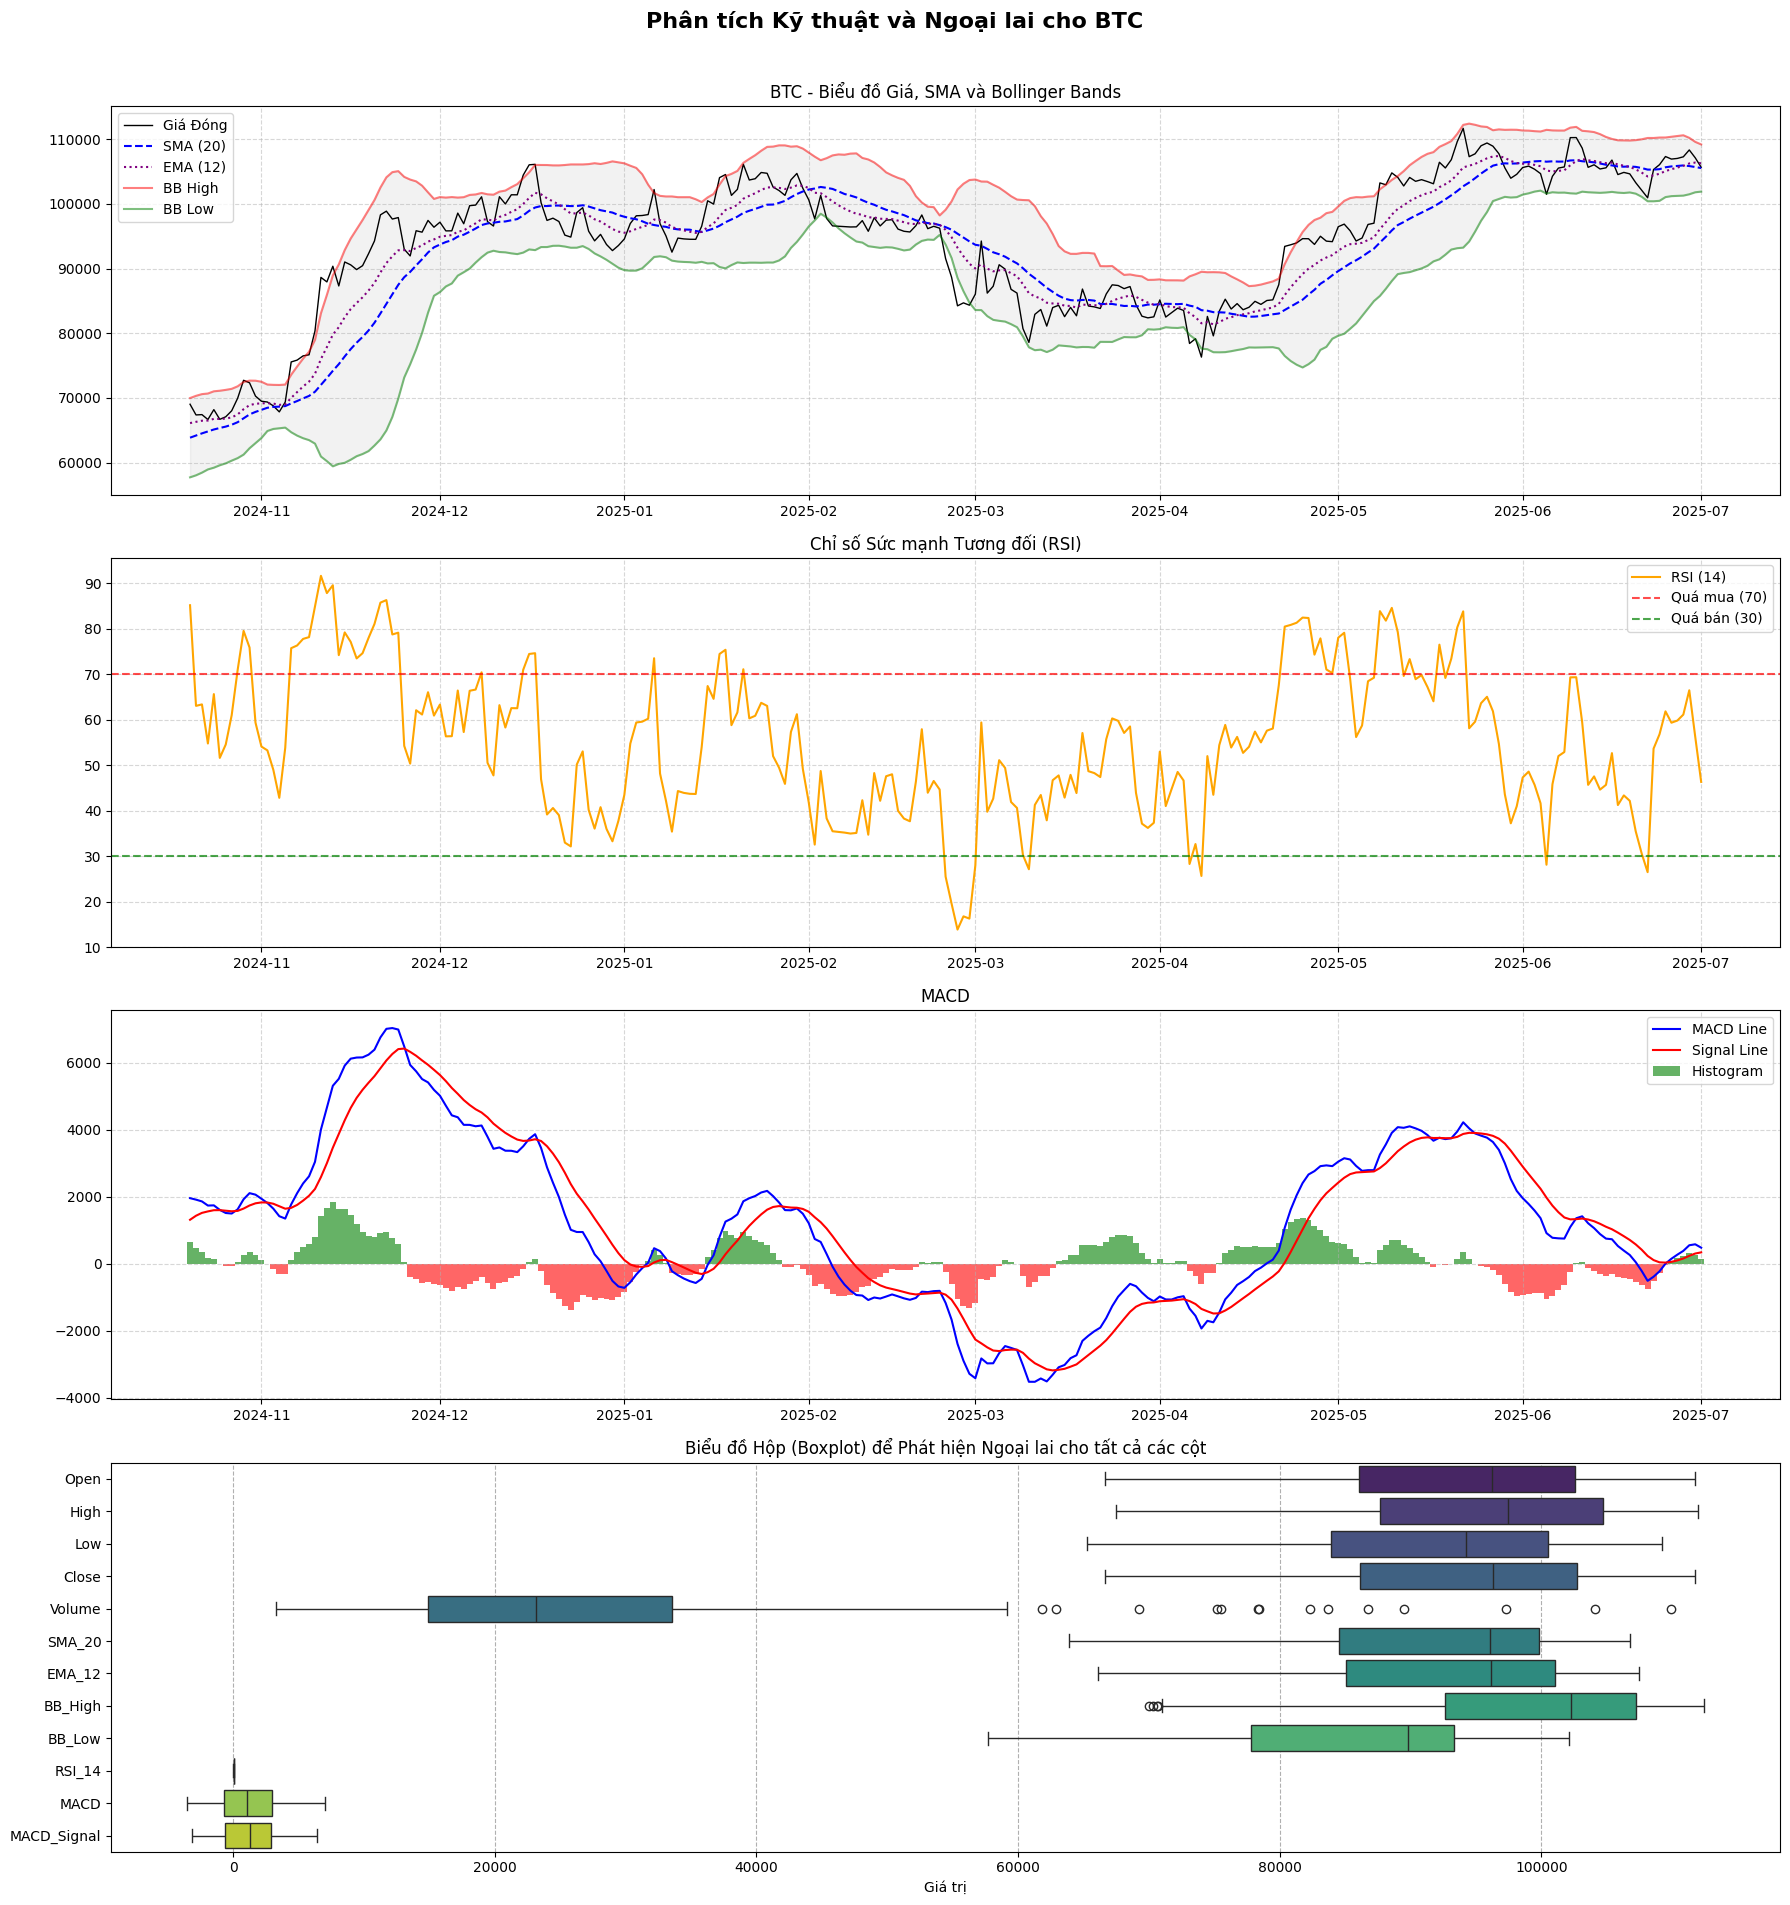

In [101]:
display_and_visualize_data(df, "BTC")